<a href="https://colab.research.google.com/github/Brun0oO/Colab/blob/main/fastapi_colab_jprq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Required python library**

In [ ]:
!pip install fastapi nest-asyncio jprq uvicorn python-multipart qrcode

     |████████████████████████████████| 51 kB 332 kB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 10.1 MB 8.1 MB/s 
     |████████████████████████████████| 60 kB 6.5 MB/s 
     |████████████████████████████████| 154 kB 56.5 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.6 MB/s 
     |████████████████████████████████| 294 kB 45.3 MB/s 
     |████████████████████████████████| 149 kB 66.5 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
  Created wheel for jprq: filename=jprq-1.3.0-py3-none-any.whl size=3695 sha256=a47f8af12999e21eeea1ef157d8c5844ba8ea4574c1792920996bac690e1b1e3
  Stored in directory: /root/.cache/pip/wheels/1e/4a/92/63bad088204186aea6d8837e50ba62949e5e8c46485a7576ca
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31679 sha256=edea559c687802c20

# **Simple FastAPI Server**

The following code launches a fastapi server delevering RESTful APIs available through a jprq tunnel. 

tunnel subprocess pid :  137
Online at https://0623795e3a0f4a71a53fa1867e67794a.jprq.live


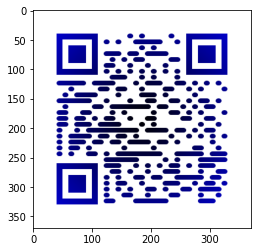

In [ ]:
import subprocess
import uuid

from fastapi import FastAPI, UploadFile, File, Form, HTTPException
from fastapi.responses import HTMLResponse, RedirectResponse

import nest_asyncio
import uvicorn
import io

import pathlib
from PIL import Image

import qrcode
from qrcode.image.styledpil import StyledPilImage
from qrcode.image.styles.moduledrawers import HorizontalBarsDrawer
from qrcode.image.styles.colormasks import RadialGradiantColorMask

import matplotlib.pyplot as plt
from time import sleep

# configure the tunnel
subdomain = uuid.uuid4().hex
port = 8000
cmd = "python3 -m jprq %s -s=%s" % (port, subdomain)
public_url = "https://%s.jprq.live" % subdomain


def createQRCode(text):
  qr = qrcode.QRCode(
      version=1,
      error_correction=qrcode.constants.ERROR_CORRECT_L,
      box_size=10,
      border=4,
  )
  qr.add_data(text)

  result = qr.make_image(image_factory=StyledPilImage, module_drawer=HorizontalBarsDrawer(), color_mask=RadialGradiantColorMask())

  return result


def processImage(img):
  result = [img.width, img.height]
  return result

app = FastAPI()

@app.get('/', response_class=HTMLResponse)
async def home():
  result = """
<h1>FastAPI with Colab is great!</h1>
<br>
<p>Some useful links:</p>
<ul>
  <li><a href="%s/docs">automatic interactive API documentation</a></li>
</ul>
  """ % (public_url)
  return result

@app.post("/analyze")
async def analyze(image: UploadFile = File(...)):
  extension = pathlib.Path(image.filename).suffix.lower()
  if not(extension in ['.png', '.jpg', '.jpeg']):
    raise HTTPException(status_code=400, detail="bad parameter, waiting for a .png or .jpg filename !")

  contents = await image.read()
  img = Image.open(io.BytesIO(contents))
  result = processImage(img)
  return {'msg': 'success', 'result': result}


@app.get("/ping")
async def ping():
  return { 'msg': 'success', 'result': 'pong'}

@app.get("/docs")
async def docs_redirect():
  response = RedirectResponse(url='/docs')
  return response





# start the tunnel in a background process
tunnel_subprocess = subprocess.Popen(cmd, shell=True)
print("tunnel subprocess pid : ", tunnel_subprocess.pid)

# serve the web app
#   display the url
print("Online at %s" % public_url)
qrcode = createQRCode(public_url)
plt.imshow(qrcode)
plt.show()
sleep(0.5)
#   launch the http server
nest_asyncio.apply() #need this patch otherwise got "RuntimeError: This event loop is already running"
uvicorn.run(app, port=port)